# Module 8

## Video 37: Predictive Modelling II
**Python for the Energy Industry**

In the previous lesson, we fit a first order autoregressive model onto floating storage data. Here, we will discuss finding the most appropriate type of ARIMA model for fitting to a time series. 

Start by getting the data:

In [1]:
# initial imports
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import vortexasdk as v
from statsmodels.tsa.arima.model import ARIMA

# The cargo unit for the time series (barrels)
TS_UNIT = 'b'

# The granularity of the time series
TS_FREQ = 'day'

# datetimes to access last 7 weeks of data
now = datetime.utcnow()
seven_weeks_ago = now - relativedelta(weeks=7)

In [2]:
# Find crude ID
crude = [p.id for p in v.Products().search('crude').to_list() if p.name=='Crude']
assert len(crude) == 1

search_result = v.CargoTimeSeries().search(
    timeseries_frequency=TS_FREQ,
    timeseries_unit=TS_UNIT,
    filter_products=crude,
    filter_time_min=seven_weeks_ago,
    filter_time_max=now,
    # Filter for cargo in floating storage
    filter_activity="storing_state",
    # Only get floating storage that lasted longer than 21 days
    timeseries_activity_time_span_min=1000 * 60 * 60 * 24 * 14,
)

df_floating_storage = search_result.to_df()
df_floating_storage = df_floating_storage.rename(columns = {'key': 'date', 'value': 'quantity'})[['date','quantity']]

An important question to ask about time series data before fitting an ARIMA model is whether the data is [stationary](https://en.wikipedia.org/wiki/Stationary_process). Non-stationary data should be differenced, using an ARIMA(p,d,q) model with d > 0. 

We can test stationarity with the Augmented Dickey Fuller test:

In [3]:
from statsmodels.tsa.stattools import adfuller
adfresult = adfuller(df_floating_storage['quantity'])
print('ADF Statistic: ', adfresult[0])
print('p-value: ', adfresult[1])

ADF Statistic:  -1.1815462355916246
p-value:  0.6814832570453857


So, we cannot reject the null hypothesis that the time series is non-stationary. What about the first order difference of the time series:

In [4]:
adfresult = adfuller(df_floating_storage['quantity'].diff().dropna())
print('ADF Statistic: ', adfresult[0])
print('p-value: ', adfresult[1])

ADF Statistic:  -7.164255346445803
p-value:  2.914087126669944e-10


So it seems that we would only need 1 order of differencing, i.e. d=1.

It's also useful to look at the autocorrelation and partial autocorrelation (where the contribution of intervening lags is removed). We will do this using the below functions from the statsmodels module, for both the original and 1-order-differenced data:

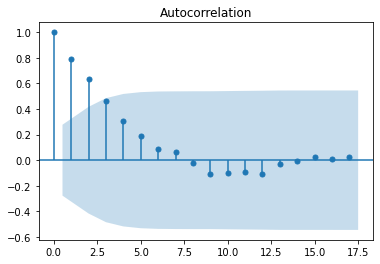

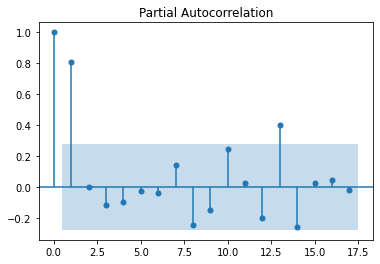

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ax1 = plot_acf(df_floating_storage['quantity'])
ax2 = plot_pacf(df_floating_storage['quantity'])

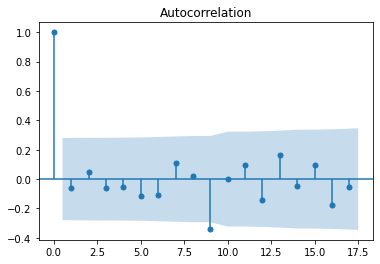

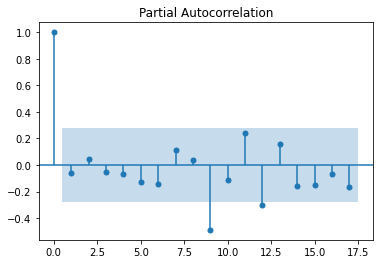

In [6]:
ax1 = plot_acf(df_floating_storage['quantity'].diff().dropna())
ax2 = plot_pacf(df_floating_storage['quantity'].diff().dropna())

From these plots, we can see that there is no autocorrelation in the differenced data, so if d=1 then we should use an ARIMA(0,1,0). 

In the original data, there is autocorrelation which is fully accounted by 1 day lag, so if using d=0 as in the previous lesson then ARIMA(1,0,0) should be optimal. 

Let's try an ARIMA(0,1,0) model, and see how it compares to our ARIMA(1,0,0) model:

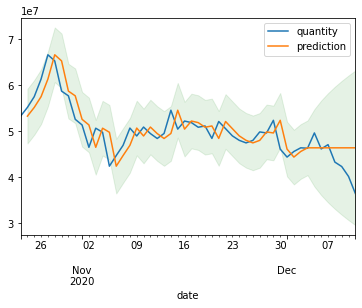

In [7]:
arima = ARIMA(df_floating_storage['quantity'].head(42),order=(0,1,0))
res = arima.fit()

pred = res.get_prediction(start=1,end=49)
df_floating_storage['prediction'] = pred.predicted_mean
df_floating_storage['lower'] = pred.conf_int()['lower quantity']
df_floating_storage['upper'] = pred.conf_int()['upper quantity']

ax = df_floating_storage.plot(x='date',y=['quantity','prediction'])
ax.fill_between(df_floating_storage['date'].values,df_floating_storage['lower'],df_floating_storage['upper'],color='g',alpha=.1)

This models performs similarly to the ARIMA(1,0,0) model. Notably, since an ARIMA(0,1,0) model is equivalent to a random walk, the out-of-sample predicted mean is a constant value. 

Finally, we can also assess different model types numerically, testing a range of different models. There are a range of metrics we can use to measure model performance, here we will use mean-square-error (MSE) and the Akaike information criterion (AIC), whiuch penalises higher order models.

Doing a loop over different sets of (p,d,q):

In [8]:
MSEs = {}
AICs = {}

for p in range(4):
    for d in range(2):
        for q in range(4):
            arima = ARIMA(df_floating_storage['quantity'].head(42),order=(p,d,q))
            res = arima.fit()
            mse = res.mse
            aic = res.aic
            MSEs[(p,d,q)] = mse
            AICs[(p,d,q)] = aic

C:\Users\Lloyd\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lloyd\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Lloyd\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lloyd\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lloyd\anaconda3\lib\site-packages\statsmodels\base\model

In [9]:
results = pd.DataFrame({'MSE':MSEs.values(),'AIC':AICs.values()},index=MSEs.keys())

In [10]:
results.head()

MSE          AIC
0 0 0  2.554974e+13  1535.782190
    1  1.354841e+13  1397.341655
    2  9.912498e+12  1383.094585
    3  9.500133e+12  1385.256180
  1 0  7.671702e+13  1343.099914

In [11]:
results[results['MSE'] < 1e13]

MSE          AIC
0 0 2  9.912498e+12  1383.094585
    3  9.500133e+12  1385.256180
1 0 0  8.525074e+12  1376.418360
    1  8.501005e+12  1378.309353
    2  8.435501e+12  1381.191926
    3  8.402791e+12  1384.744361
2 0 0  8.495810e+12  1378.286910
    1  8.190029e+12  1378.465350
    2  8.138664e+12  1381.179028
    3  9.930077e+12  1391.063531
3 0 0  8.404489e+12  1379.835533
    1  8.147085e+12  1380.360607
    2  7.587775e+12  1378.696377
    3  7.555709e+12  1380.509978

Here, only models with d=0 yield an MSE below 1e13. Of these, the model which minimizes AIC is ARIMA(1,0,0).

### Exercise

Determine which order of ARIMA model is best for the US crude exports data.